# Project:Movie Genre Prediction

Made by Vedant Dhoke

This notebook is designed to predict movie genres based on plot descriptions using natural language processing and machine learning techniques. The script begins by loading a dataset of movies, which includes plot descriptions and associated genres. It preprocesses the plot descriptions using SpaCy, a natural language processing library, to lemmatize the text and remove stop words and punctuation. Missing values in the 'Plot' column are filled with empty strings, and all plot data is ensured to be in string format.

To better understand the data, several visualizations are created. The distribution of the top 10 movie genres is visualized using a bar plot. A word cloud is generated to highlight the most common words in the plot descriptions. Additionally, the average length of plot descriptions by genre is plotted, and a box plot is used to show the distribution of plot description lengths by genre. A heatmap is created to show the co-occurrence of the top genres, providing insights into genre combinations in the dataset.

The core of the notebook involves building and evaluating a machine learning model to predict movie genres based on plot descriptions. A pipeline is defined using TfidfVectorizer for feature extraction and Multinomial Naive Bayes for classification. The dataset is split into training and testing sets, and the model is trained on the training data. The model's performance is evaluated on the test data, with accuracy and classification reports generated. Additionally, 5-fold cross-validation is performed to assess the model's robustness, achieving an accuracy of approximately 36%.

The trained model is saved to a file for future use, and the DataFrame with predicted genres is saved to a CSV file. This notebook provides a comprehensive approach to text classification, showcasing the steps from data preprocessing and visualization to model training, evaluation, and saving. The model, despite its moderate accuracy, demonstrates the application of natural language processing and machine learning techniques in predicting movie genres based on plot descriptions.

In [10]:
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from wordcloud import WordCloud


nlp = spacy.load('en_core_web_sm')


df = pd.read_csv('movies.csv')



Data Preprocessing

In [11]:

def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)


df['Plot'] = df['Plot'].fillna('')
df['Plot'] = df['Plot'].astype(str)
df = df.dropna(subset=['Genre'])




In [12]:
df['cleaned_plot'] = df['Plot'].apply(preprocess_text)
print(df[['cleaned_plot', 'Genre']].isnull().sum())

cleaned_plot    0
Genre           0
dtype: int64


Data Visualization

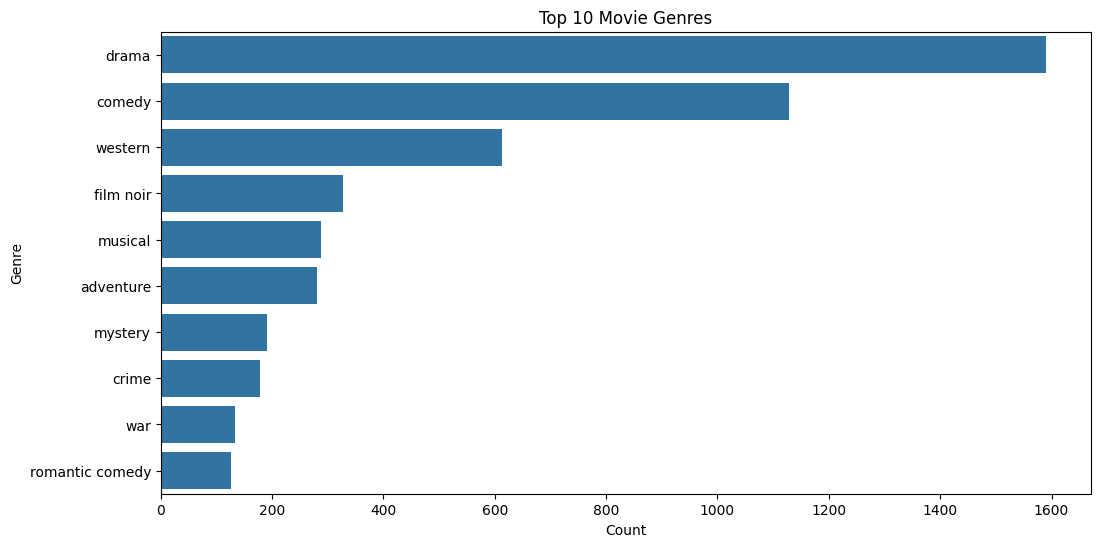

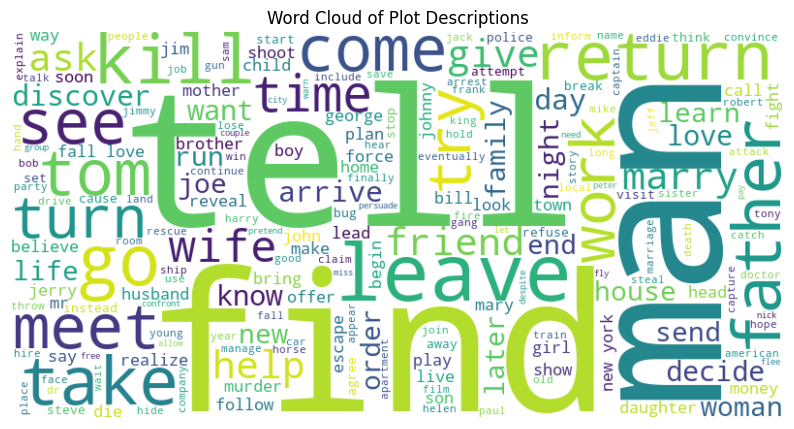

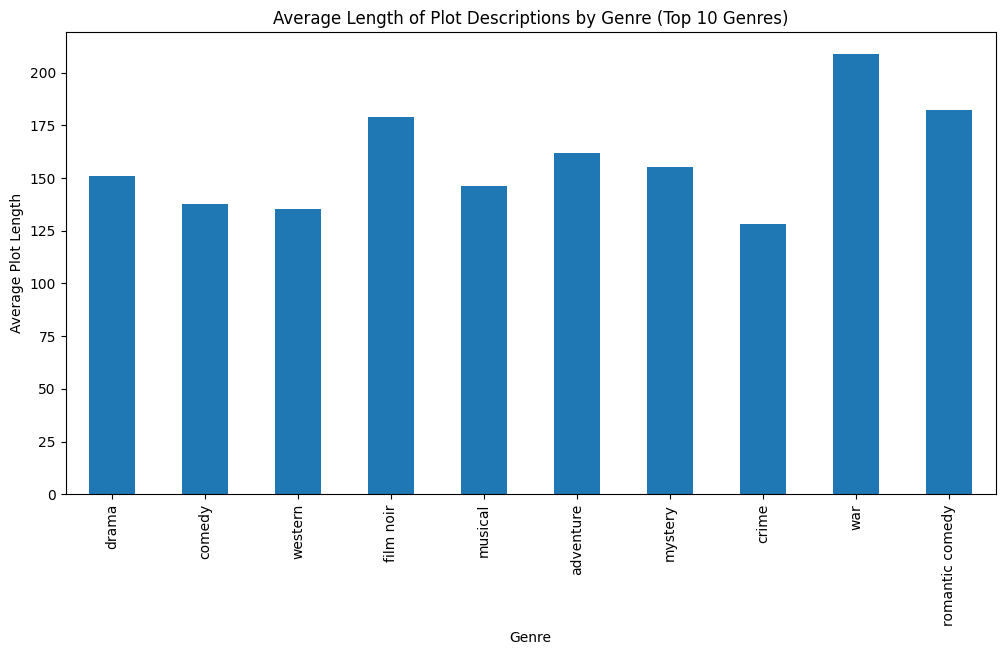

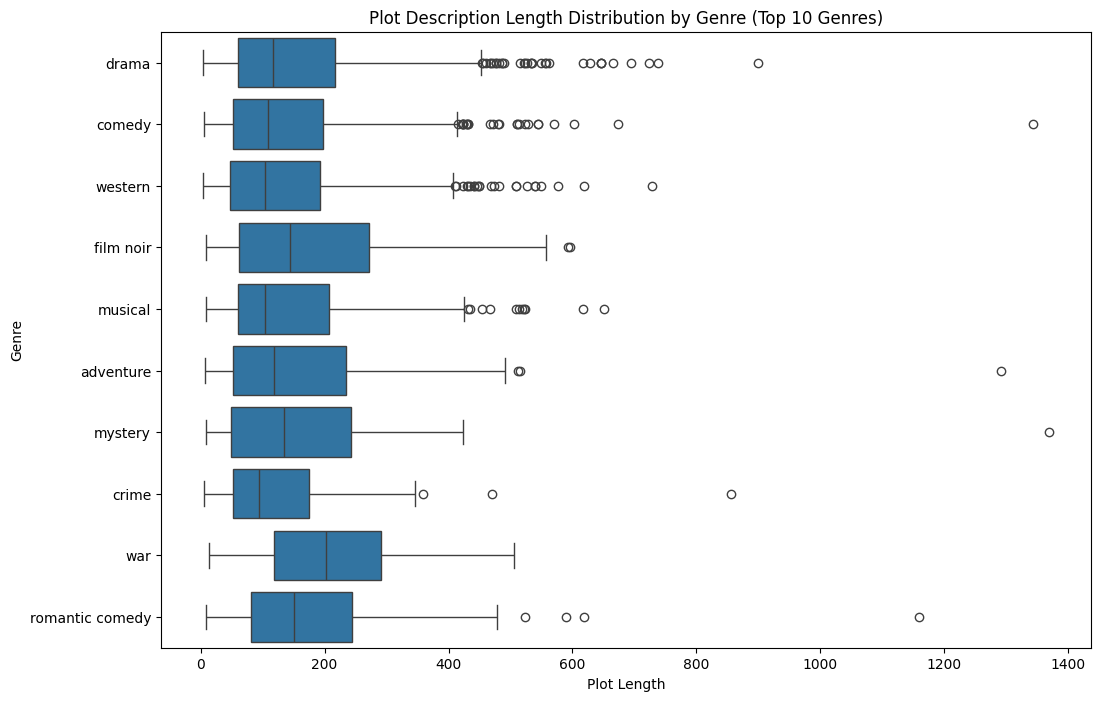

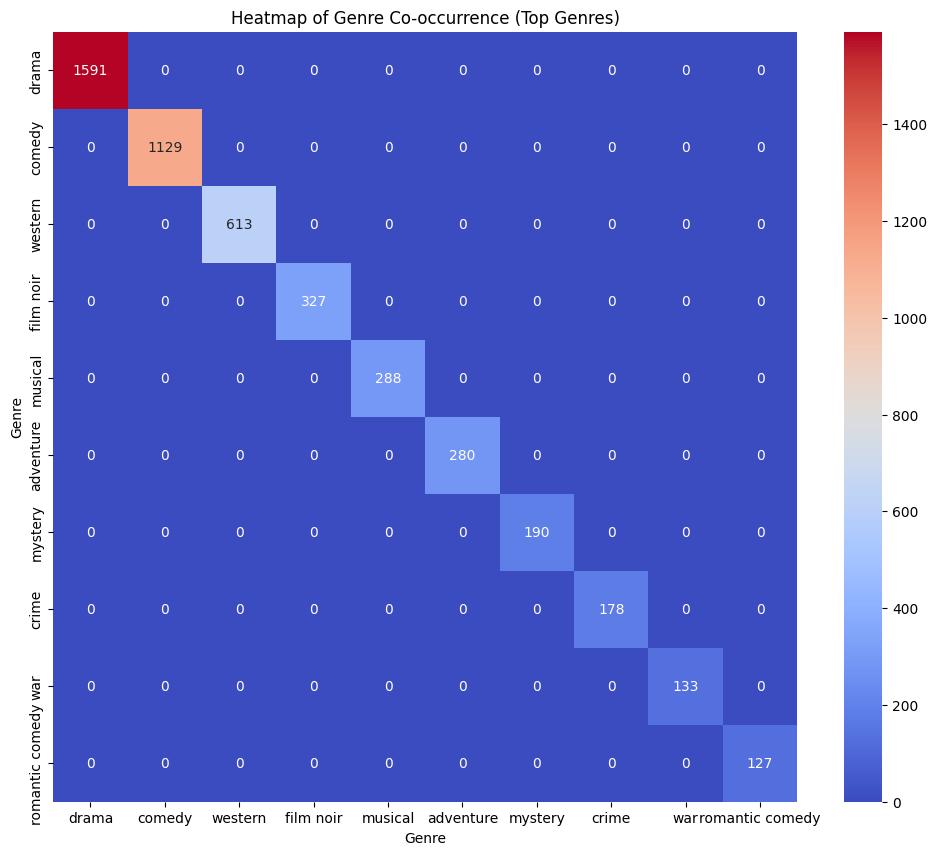

In [13]:

top_n = 10
top_genres = df['Genre'].value_counts().nlargest(top_n).index

plt.figure(figsize=(12, 6))
sns.countplot(y=df[df['Genre'].isin(top_genres)]['Genre'], order=top_genres)
plt.title(f'Top {top_n} Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


all_text = ' '.join(df['cleaned_plot'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Plot Descriptions')
plt.show()


df['plot_length'] = df['cleaned_plot'].apply(lambda x: len(x.split()))
avg_plot_length = df[df['Genre'].isin(top_genres)].groupby('Genre')['plot_length'].mean().reindex(top_genres)

plt.figure(figsize=(12, 6))
avg_plot_length.plot(kind='bar')
plt.title(f'Average Length of Plot Descriptions by Genre (Top {top_n} Genres)')
plt.xlabel('Genre')
plt.ylabel('Average Plot Length')
plt.show()



plt.figure(figsize=(12, 8))
sns.boxplot(x='plot_length', y='Genre', data=df[df['Genre'].isin(top_genres)], order=top_genres)
plt.title(f'Plot Description Length Distribution by Genre (Top {top_n} Genres)')
plt.xlabel('Plot Length')
plt.ylabel('Genre')
plt.show()


df['Genres'] = df['Genre'].apply(lambda x: x.split('|'))
genre_combinations = df.explode('Genres')['Genres'].value_counts().index[:top_n]

    
co_occurrence = pd.DataFrame(0, index=genre_combinations, columns=genre_combinations)

for genres in df['Genres']:
    for genre in genres:
        if genre in co_occurrence.index:
            co_occurrence.loc[genre, genres] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, annot=True, fmt='d', cmap='coolwarm')
plt.title('Heatmap of Genre Co-occurrence (Top Genres)')
plt.xlabel('Genre')
plt.ylabel('Genre')
plt.show()

Training and Evaluating the Model


In [14]:

# Define the feature extraction and model pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', MultinomialNB())
])


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_plot'], df['Genre'], test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))
joblib.dump(pipeline, 'movie_genre_classifier.pkl')
df['predicted_genre'] = pipeline.predict(df['cleaned_plot'])
df.to_csv('movies_with_predictions.csv', index=False)

Accuracy: 0.33
                                   precision    recall  f1-score   support

                           action       0.00      0.00      0.00         7
                 action adventure       0.00      0.00      0.00         2
                    action comedy       0.00      0.00      0.00         1
                  action, western       0.00      0.00      0.00         1
                        adventure       0.00      0.00      0.00        54
                 adventure serial       0.00      0.00      0.00         2
              adventure, thriller       0.00      0.00      0.00         1
                       adventures       0.00      0.00      0.00         1
                american football       0.00      0.00      0.00         1
                         animated       0.00      0.00      0.00        15
                    animated film       0.00      0.00      0.00         1
                  animated series       0.00      0.00      0.00         1
         

c:\Users\ravin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ravin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ravin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [16]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, df['cleaned_plot'], df['Genre'], cv=5)
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())


c:\Users\ravin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.32928571 0.34142857 0.33571429 0.33785714 0.34285714]
Mean accuracy: 0.33742857142857147
